In [77]:
import sys
sys.path.append('../')

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from load_dataset import Dataset
import plotting

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
dataset = Dataset('../data/Dataset')

In [81]:
ts = dataset['international-airline-passengers.csv']
ts.index = ts.index.map(pd.to_datetime)

In [82]:
ts, ts_test = ts[:100], ts[100:]

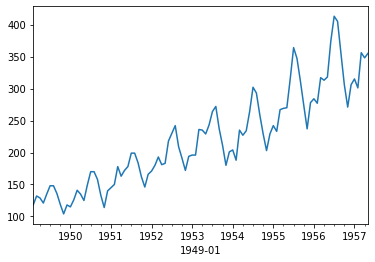

In [83]:
ts.plot()

In [30]:
ts.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01', '1949-12-01', '1950-01-01',
               '1950-02-01', '1950-03-01', '1950-04-01', '1950-05-01',
               '1950-06-01', '1950-07-01', '1950-08-01', '1950-09-01',
               '1950-10-01', '1950-11-01', '1950-12-01', '1951-01-01',
               '1951-02-01', '1951-03-01', '1951-04-01', '1951-05-01',
               '1951-06-01', '1951-07-01', '1951-08-01', '1951-09-01',
               '1951-10-01', '1951-11-01', '1951-12-01', '1952-01-01',
               '1952-02-01', '1952-03-01', '1952-04-01', '1952-05-01',
               '1952-06-01', '1952-07-01', '1952-08-01', '1952-09-01',
               '1952-10-01', '1952-11-01', '1952-12-01', '1953-01-01',
               '1953-02-01', '1953-03-01', '1953-04-01', '1953-05-01',
               '1953-06-01', '1953-07-01', '1953-08-01', '1953-09-01',
      

In [85]:
ts_log = np.log(ts)

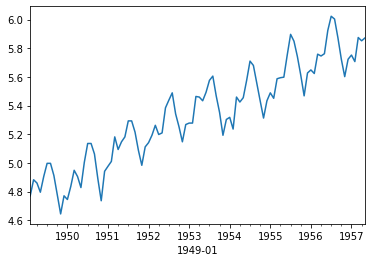

In [86]:
ts_log.plot()

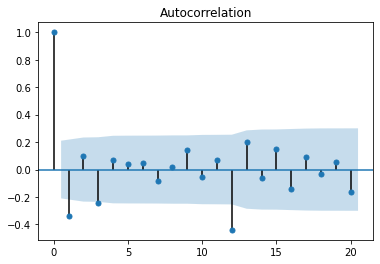

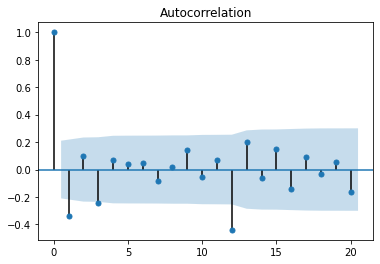

In [93]:
plot_acf(ts_log.diff(12).diff(1).dropna())

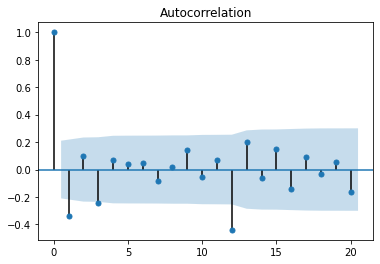

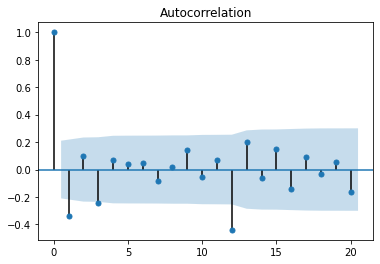

In [95]:
plot_acf(ts_log.diff(12).diff(1).dropna())
# q, Q = (1, 1)

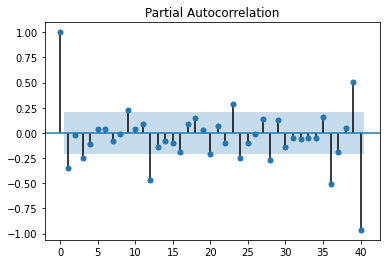

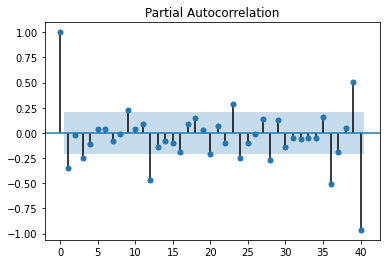

In [98]:
plot_pacf(ts_log.diff(12).diff().dropna(), lags=40)
# (p, P) = (1, 1)

In [99]:
from statsmodels.tsa.statespace import sarimax

In [100]:
pdq = (1, 1, 1)
PDQ = (1, 1, 1, 12)
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

In [101]:
res = model.fit()

In [102]:
preds = res.forecast(len(ts_test))

In [103]:
plotting.plot_multiple_ts(ts, np.exp(preds), ts_test)

In [104]:
res = np.exp(preds) - ts_test

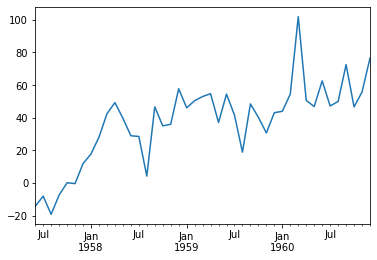

In [105]:
res.plot()

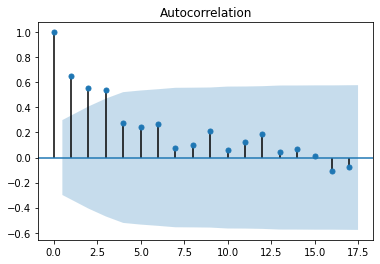

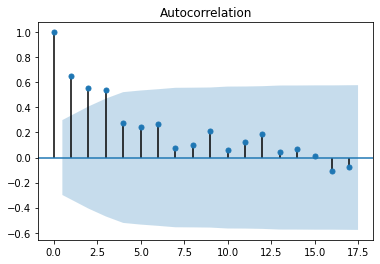

In [106]:
plot_acf(res)

In [107]:
adfuller(res)

(-2.38501620613054,
 0.1460102096384746,
 8,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 266.85088367099354)

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot.
3. Оценить параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMA и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели - стационарные остатки.

#### Задание 2. (используя критерий Акаике)
1. Выбрать сетку гиперпараметров.
2. Пройтись по сетке, обучая модель и считая aic на тестовой выборке.
3. Выбрать модель с набором гиперпараметров, дающих минимальный aic. 

In [108]:
def calculate_akaike(y_true: np.array, y_pred: np.array, n_params: int):
    L = sum((y_true - y_pred)**2)
    n = len(y_true)
    return 2*n_params + n*np.log(L)

In [1]:
import itertools

p, q = range(0, 3), range(0, 3)
d = [0, 1]
pdq = list(itertools.product(p, d, q))

PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
from numpy.linalg.linalg import LinAlgError


for pdq_, PDQ_ in zip(pdq, PDQ):
    model = sarimax.SARIMAX(ts_log, order=pdq_, seasonal_order=PDQ_)
    res = model.fit()
    try:
        print(pdq_, PDQ_)
        print(res.aic)
    except BaseException as e:
        continue

(0, 0, 0) (0, 0, 0, 12)
-181.6484634183218
(0, 0, 1) (0, 0, 1, 12)
-212.89888788256528
(0, 0, 2) (0, 0, 2, 12)
-245.31938821535658
(0, 1, 0) (0, 1, 0, 12)
-295.10483441880024
(0, 1, 1) (0, 1, 1, 12)
-303.8677706463685
(0, 1, 2) (0, 1, 2, 12)
-302.18301072588287
(1, 0, 0) (1, 0, 0, 12)
-294.469525075312
(1, 0, 1) (1, 0, 1, 12)
-304.5193433917452
(1, 0, 2) (1, 0, 2, 12)
-300.26900921381224
(1, 1, 0) (1, 1, 0, 12)
-302.536349714962
(1, 1, 1) (1, 1, 1, 12)
-302.56651884616116
(1, 1, 2) (1, 1, 2, 12)
-299.86684047711486
(2, 0, 0) (2, 0, 0, 12)
-302.75007969412013
(2, 0, 1) (2, 0, 1, 12)
-299.8981745385861
(2, 0, 2) (2, 0, 2, 12)
-299.5731766607354
(2, 1, 0) (2, 1, 0, 12)
-300.68464191540215
(2, 1, 1) (2, 1, 1, 12)
-300.0563429725378
(2, 1, 2) (2, 1, 2, 12)
-300.10088334591893
